In [2]:
# ================================
#   YOLOv11 + BDD100K Colab Notebook
# ================================

# ================================
# 1. Install Dependencies
# ================================
!pip install ultralytics --quiet
!pip install tqdm jsonlines --quiet
!pip install roboflow --quiet

print("Ultralytics + Dependencies Installed!")


Ultralytics + Dependencies Installed!


In [5]:
# ================================
# 2. Mount Google Drive
# ================================

ROOT = "/content/BDD100K_YOLO"
os.makedirs(ROOT, exist_ok=True)

In [7]:
# ================================
# 3. Download BDD100K Dataset (Detection labels only)
# ================================
# Official Downloads:
# Images: https://bdd-data.berkeley.edu/
# Labels: https://bdd-data.berkeley.edu/

!wget http://128.32.162.150/bdd100k/bdd100k_images_100k.zip -O {ROOT}/bdd100k_images.zip
!wget http://128.32.162.150/bdd100k/bdd100k_labels.zip -O {ROOT}/bdd100k_labels.zip


--2025-11-17 21:12:22--  http://128.32.162.150/bdd100k/bdd100k_images_100k.zip
Connecting to 128.32.162.150:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5669071832 (5.3G) [application/zip]
Saving to: ‘/content/BDD100K_YOLO/bdd100k_images.zip’

/content/BDD100K_YO 100%[===================>]   5.28G  5.44MB/s    in 11m 19s 

2025-11-17 21:23:42 (7.96 MB/s) - ‘/content/BDD100K_YOLO/bdd100k_images.zip’ saved [5669071832/5669071832]

--2025-11-17 21:23:42--  http://128.32.162.150/bdd100k/bdd100k_labels.zip
Connecting to 128.32.162.150:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189638612 (181M) [application/zip]
Saving to: ‘/content/BDD100K_YOLO/bdd100k_labels.zip’

/content/BDD100K_YO 100%[===================>] 180.85M  11.3MB/s    in 14s     

2025-11-17 21:23:56 (12.9 MB/s) - ‘/content/BDD100K_YOLO/bdd100k_labels.zip’ saved [189638612/189638612]



In [8]:
# Extract everything

# Folder Structure After Extraction:
# ROOT/bdd100k/images/100k/{train,val}
# ROOT/bdd100k/labels/det_20/{train,val}.json

print("Extracting images ...")
!unzip -q {ROOT}/bdd100k_images.zip -d {ROOT}/images_100k

print("Extracting labels ...")
!unzip -q {ROOT}/bdd100k_labels.zip -d {ROOT}/labels_100k

print("Extraction Complete!")



Extracting images ...
Extracting labels ...
Extraction Complete!


In [22]:
# debugging to check annotations are written in labels
"""
import os
import json

classes = {
    "person": 0, "rider": 1, "car": 2, "bus": 3, "truck": 4,
    "bike": 5, "motorcycle": 6, "traffic light": 7,
    "traffic sign": 8, "train": 9
}
json_path = f"/content/BDD100K_YOLO/labels/train/0000f77c-6257be58.json"
with open(json_path, 'r') as jf:
  ann = json.load(jf)
  #shutil.copy(img_path, f"{out_img_dir}/{img_name}")

# Height/width fallback
  h = ann.get("height", 720)
  w = ann.get("width", 1280)

# Open output label file
  out_lbl_path = f"/content/BDD100K_YOLO/0000f77c-6257be58.txt"
  with open(out_lbl_path, "w") as out_f:

    frame_objects = ann.get("frames", [{}])[0].get("objects", [])

    # Loop through annotations
    for obj in frame_objects:
        cls_name = obj.get("category")

        # Skip unknown classes
        if cls_name not in classes:
            continue

        # Bounding box
        box = obj.get("box2d", None)
        if not box:
            continue

        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

        # Convert to YOLO format
        xc = (x1 + x2) / 2 / w
        yc = (y1 + y2) / 2 / h
        bw = (x2 - x1) / w
        bh = (y2 - y1) / h

        out_f.write(f"{classes[cls_name]} {xc} {yc} {bw} {bh}\n")
"""

In [23]:
import os
import json
import shutil
from tqdm import tqdm

def convert_split(split, IMG_DIR, JSON_DIR, OUT_DIR, classes):
    """
    Convert per-image JSON annotations to YOLO TXT format.

    Args:
        split (str): "train", "val", or "test"
        IMG_DIR (str): path to image directory containing JPGs
        JSON_DIR (str): path to directory containing JSON files (one per image)
        OUT_DIR (str): output directory root to save YOLO images/labels
        classes (dict): category→index mapping
    """

    print(f"\n🔄 Converting split: {split}")

    # Make output directories
    out_img_dir = f"{OUT_DIR}/{split}/images"
    out_lbl_dir = f"{OUT_DIR}/{split}/labels"
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    # Get all images for this split
    image_list = sorted([f for f in os.listdir(f"{IMG_DIR}/{split}") if f.endswith('.jpg')])

    for img_name in tqdm(image_list):

        img_path = f"{IMG_DIR}/{split}/{img_name}"

        # EXPECT JSON NAMED SAME AS IMAGE (e.g., 00001.jpg → 00001.json)
        json_name = img_name.replace(".jpg", ".json")
        json_path = f"{JSON_DIR}/{split}/{json_name}"

        # Check if JSON exists
        if not os.path.exists(json_path):
            print(f"⚠️ Missing annotation: {json_path} (skipping)")
            continue

        # Load annotation JSON
        with open(json_path, 'r') as jf:
            ann = json.load(jf)

        # Copy image to YOLO dataset
        shutil.copy(img_path, f"{out_img_dir}/{img_name}")

        # Height/width fallback
        h = ann.get("height", 720)
        w = ann.get("width", 1280)

        # Open output label file
        out_lbl_path = f"{out_lbl_dir}/{img_name.replace('.jpg', '.txt')}"
        with open(out_lbl_path, "w") as out_f:

            frame_objects = ann.get("frames", [{}])[0].get("objects", [])
            # Loop through annotations
            for obj in frame_objects:
                cls_name = obj.get("category")

                # Skip unknown classes
                if cls_name not in classes:
                    continue

                # Bounding box
                box = obj.get("box2d", None)
                if not box:
                    continue

                x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

                # Convert to YOLO format
                xc = (x1 + x2) / 2 / w
                yc = (y1 + y2) / 2 / h
                bw = (x2 - x1) / w
                bh = (y2 - y1) / h

                out_f.write(f"{classes[cls_name]} {xc} {yc} {bw} {bh}\n")

    print(f"✅ Completed {split}")


# ========================
# Example Usage
# ========================

classes = {
    "person": 0, "rider": 1, "car": 2, "bus": 3, "truck": 4,
    "bike": 5, "motorcycle": 6, "traffic light": 7,
    "traffic sign": 8, "train": 9
}

IMG_DIR = "/content/BDD100K_YOLO/images_100k"           # contains train/, val/, test/
JSON_DIR = "/content/BDD100K_YOLO/labels_100k"     # contains train/, val/, test/
OUT_DIR = "/content/BDD100K_YOLO/dataset"

convert_split("train", IMG_DIR, JSON_DIR, OUT_DIR, classes)
convert_split("val", IMG_DIR, JSON_DIR, OUT_DIR, classes)
convert_split("test", IMG_DIR, JSON_DIR, OUT_DIR, classes)



🔄 Converting split: train


100%|██████████| 70000/70000 [00:34<00:00, 2037.84it/s]


✅ Completed train

🔄 Converting split: val


100%|██████████| 10000/10000 [00:05<00:00, 1846.06it/s]


✅ Completed val

🔄 Converting split: test


100%|██████████| 20000/20000 [00:10<00:00, 1911.81it/s]

✅ Completed test


In [26]:
# ================================
# 5. Create YAML File for Training
# ================================
yaml_path = f"{ROOT}/bdd100k.yaml"
with open(yaml_path, "w") as f:
    f.write(f"""
path: {ROOT}/dataset

train: train/images
val: val/images
test: test/images

names:
  0: person
  1: rider
  2: car
  3: bus
  4: truck
  5: bike
  6: motorcycle
  7: traffic light
  8: traffic sign
  9: train

    """)

print("bdd100k.yaml created!")



bdd100k.yaml created!


In [ ]:
from ultralytics import YOLO
import os, json, shutil, zipfile
from tqdm import tqdm

# ===========================================
# 1) Train YOLOv11 + Save Fine-Tuned Model
# ===========================================

save_dir = "yolo11m_bdd100k"
os.makedirs(save_dir, exist_ok=True)

model = YOLO("yolo11m.pt")

results = model.train(
    data=yaml_path,
    imgsz=640,
    epochs=5,
    batch=32,
    device=0,
    workers=2,
    project="yolo11m_bdd100k",        # save training logs here
    name="train_run",
    save=True,
    save_period=1            # save checkpoint every epoch
)

print("✔ Training Completed!")
print(f"✔ Saved fine-tuned weights at: {save_dir}/train_run/weights/")

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.15 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/BDD100K_YOLO/bdd100k.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=2, project=yolo11m_bdd100k, name=train_run3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, emb

train: Scanning /content/BDD100K_YOLO/dataset/train/labels... 70000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70000/70000 [00:49<00:00, 1420.76it/s]

train: WARNING ⚠️ /content/BDD100K_YOLO/dataset/train/images/75055858-7d04a650.jpg: 1 duplicate labels removed


train: New cache created: /content/BDD100K_YOLO/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/BDD100K_YOLO/dataset/val/labels... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:07<00:00, 1370.71it/s]


val: New cache created: /content/BDD100K_YOLO/dataset/val/labels.cache
Plotting labels to yolo11m_bdd100k/train_run3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolo11m_bdd100k/train_run3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      18.5G      1.308     0.9077          1        614        640: 100%|██████████| 2188/2188 [09:47<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:45<00:00,  3.44it/s]


                   all      10000     185126        0.6      0.381      0.391      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      17.4G      1.297     0.8151     0.9979        523        640: 100%|██████████| 2188/2188 [09:42<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:44<00:00,  3.51it/s]


                   all      10000     185126      0.669      0.421      0.456      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      17.8G      1.269     0.7788      0.986        462        640: 100%|██████████| 2188/2188 [09:26<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:45<00:00,  3.47it/s]


                   all      10000     185126      0.668      0.439       0.47      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      17.9G      1.239     0.7433     0.9745        532        640: 100%|██████████| 2188/2188 [09:36<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:44<00:00,  3.50it/s]


                   all      10000     185126      0.705      0.455      0.505      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      17.9G      1.203     0.6998     0.9613        479        640: 100%|██████████| 2188/2188 [09:35<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:44<00:00,  3.53it/s]


                   all      10000     185126      0.719      0.476      0.527      0.303

5 epochs completed in 0.872 hours.
Optimizer stripped from yolo11m_bdd100k/train_run3/weights/last.pt, 40.5MB
Optimizer stripped from yolo11m_bdd100k/train_run3/weights/best.pt, 40.5MB

Validating yolo11m_bdd100k/train_run3/weights/best.pt...
Ultralytics 8.3.15 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m summary (fused): 303 layers, 20,037,742 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [01:10<00:00,  2.22it/s]


                   all      10000     185126      0.719      0.477      0.527      0.303
                person       3220      13265      0.698      0.563      0.624      0.315
                 rider        515        649      0.613      0.393      0.426      0.211
                   car       9879     102540      0.786      0.721      0.784      0.491
                   bus       1242       1597      0.696      0.523      0.611      0.474
                 truck       2689       4247      0.639      0.582      0.625      0.455
                  bike        578       1007      0.611      0.388      0.429      0.206
         traffic light       5653      26891      0.713       0.53      0.592      0.229
          traffic sign       8221      34915      0.716      0.589      0.651      0.347
                 train         14         15          1          0    0.00222    0.00174
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to yolo11m_bdd

lr/pg0,▃▇█▅▁
lr/pg1,▃▇█▅▁
lr/pg2,▃▇█▅▁
metrics/mAP50(B),▁▄▅▇█
metrics/mAP50-95(B),▁▄▅▇█
metrics/precision(B),▁▅▅▇█
metrics/recall(B),▁▄▅▆█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


✔ Training Completed!
✔ Saved fine-tuned weights at: /content/BDD100K_YOLO/train_run/weights/


In [ ]:
# ===========================================
# 1) Save fine-tuned YOLO model
# ===========================================

model_path = "/content/BDD100K_YOLO/yolo_finetuned_bdd100k.pt"
model.save(model_path)
print(f"✔ Fine-tuned model saved at: {model_path}")

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# ===========================================
# 2) Generate Validation Performance Metrics
# ===========================================

print("\n📊 Generating Evaluation Metrics...")

metrics = model.val()    # runs validation & returns DetMetrics object


# ===========================================
# 3) Write metrics to a readable text file
# ===========================================

metrics_path = f"{save_dir}/metrics_summary.txt"

with open(metrics_path, "w") as f:

    f.write("===== YOLO Validation Metrics =====\n\n")
    f.write(f"mAP@50:       {metrics.box.map50:.4f}\n")
    f.write(f"mAP@50-95:    {metrics.box.map:.4f}\n")
    f.write(f"Precision:    {metrics.box.mp:.4f}\n")
    f.write(f"Recall:       {metrics.box.mr:.4f}\n\n")

    # per-class AP if available
    if hasattr(metrics.box, "ap_class_index"):
        f.write("===== Per-Class AP =====\n")
        for cls_idx, ap in zip(metrics.box.ap_class_index, metrics.box.ap):
            f.write(f"class {cls_idx}: AP = {ap:.4f}\n")

print("✔ Metrics written to:", metrics_path)


# ===========================================
# 4) Print summary metrics to notebook output
# ===========================================

print("\n===== VAL METRICS =====")
print(f"mAP50:     {metrics.box.map50:.4f}")
print(f"mAP50-95:  {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall:    {metrics.box.mr:.4f}")


# ===========================================
# 5) Save Confusion Matrix Image
# ===========================================

if hasattr(metrics, "confusion_matrix") and metrics.confusion_matrix is not None:
    metrics.confusion_matrix.plot(
        normalize=True,
        save_dir=save_dir
    )
    print(f"✔ Confusion matrix saved in {save_dir}")

else:
    print("⚠ No confusion matrix found (possibly empty dataset or configuration).")




📊 Generating Evaluation Metrics...
Ultralytics 8.3.15 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/BDD100K_YOLO/dataset/val/labels.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:18<00:00,  3.97it/s]


                   all      10000     185126      0.719      0.477      0.528      0.304
                person       3220      13265      0.697      0.562      0.623      0.316
                 rider        515        649      0.617      0.394      0.428      0.211
                   car       9879     102540      0.785      0.722      0.784      0.492
                   bus       1242       1597      0.693      0.524      0.611      0.474
                 truck       2689       4247      0.637      0.582      0.625      0.455
                  bike        578       1007      0.613      0.389      0.433      0.207
         traffic light       5653      26891      0.713      0.532      0.593       0.23
          traffic sign       8221      34915      0.716      0.591      0.652      0.349
                 train         14         15          1          0     0.0022    0.00172
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to yolo11m_bdd

In [32]:
# ===========================================
# 3) Plot Train/Val Loss & Accuracy Curves
# ===========================================

print("\n📉 Generating Training Curves...")

csv_path = f"{save_dir}/train_run/results.csv"

df = pd.read_csv(csv_path)

plt.figure(figsize=(14, 8))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')

plt.title("YOLOv11 Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/loss_curves.png")
plt.show()

# Accuracy metrics plot (Precision, Recall, mAP)
plt.figure(figsize=(14, 8))
plt.plot(df['epoch'], df['metrics/precision(B)'], label="Precision")
plt.plot(df['epoch'], df['metrics/recall(B)'], label="Recall")
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label="mAP50")
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label="mAP50-95")

plt.title("YOLOv11 Accuracy Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.savefig(f"{save_dir}/metric_curves.png")
plt.show()

print("✔ Training curves saved in:", save_dir)



📉 Generating Training Curves...


FileNotFoundError: [Errno 2] No such file or directory: '/content/BDD100K_YOLO/train_run/results.csv'

In [34]:
# ===========================================
# 4) Run Inference on Test Dataset
# ===========================================

print("\n🔍 Running Inference on TEST Images...")

test_results_dir = "/content/BDD100K_YOLO/test_preds"
os.makedirs(test_results_dir, exist_ok=True)

preds = model.predict(
    source=f"{ROOT}/dataset/test/images",
    imgsz=640,
    save=True,
    project=test_results_dir,
    name="preds",
    conf=0.25
)

print("✔ Inference Completed!")
print("✔ Output saved at:", test_results_dir + "/preds")

Streaming output truncated to the last 5000 lines.
image 15005/20000 /content/BDD100K_YOLO/dataset/test/images/f0f1dc8a-1fc4d9d7.jpg: 384x640 2 persons, 18 cars, 1 truck, 4 traffic lights, 4 traffic signs, 11.0ms
image 15006/20000 /content/BDD100K_YOLO/dataset/test/images/f0f1dc8a-34648cd7.jpg: 384x640 14 cars, 5 traffic lights, 2 traffic signs, 11.5ms
image 15007/20000 /content/BDD100K_YOLO/dataset/test/images/f0f42f62-7452aa4e.jpg: 384x640 7 cars, 11.4ms
image 15008/20000 /content/BDD100K_YOLO/dataset/test/images/f0f44f75-8807c69f.jpg: 384x640 1 car, 1 traffic light, 4 traffic signs, 11.8ms
image 15009/20000 /content/BDD100K_YOLO/dataset/test/images/f0f457ca-79602501.jpg: 384x640 5 cars, 1 truck, 1 traffic sign, 11.8ms
image 15010/20000 /content/BDD100K_YOLO/dataset/test/images/f0f457ca-bad71eec.jpg: 384x640 17 cars, 5 traffic lights, 6 traffic signs, 11.2ms
image 15011/20000 /content/BDD100K_YOLO/dataset/test/images/f0f48899-35e26e5a.jpg: 384x640 6 traffic signs, 11.7ms
image 15012/

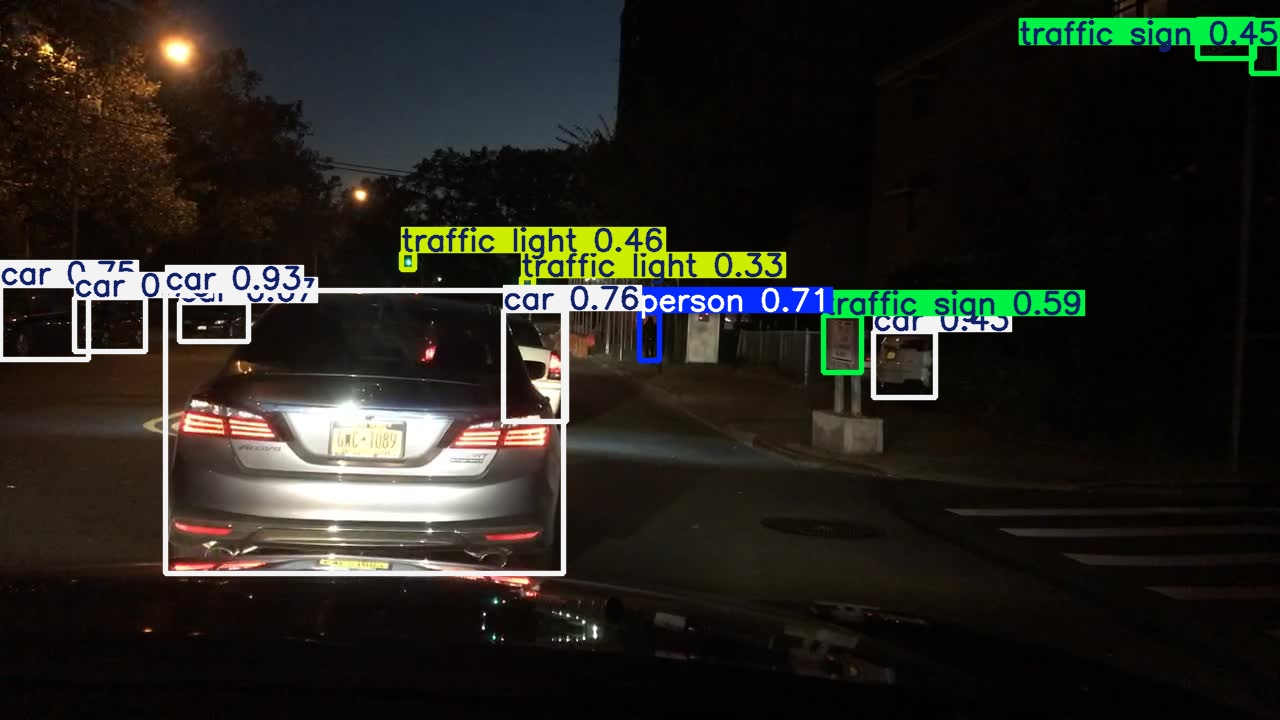

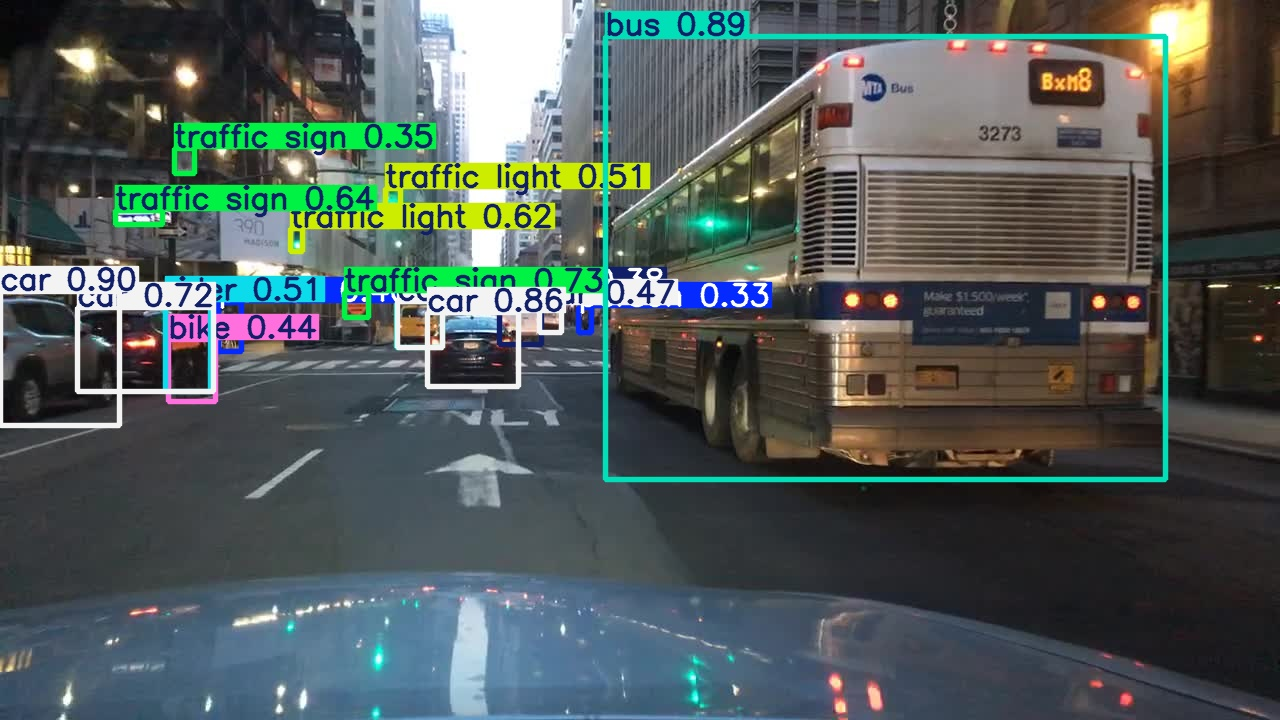

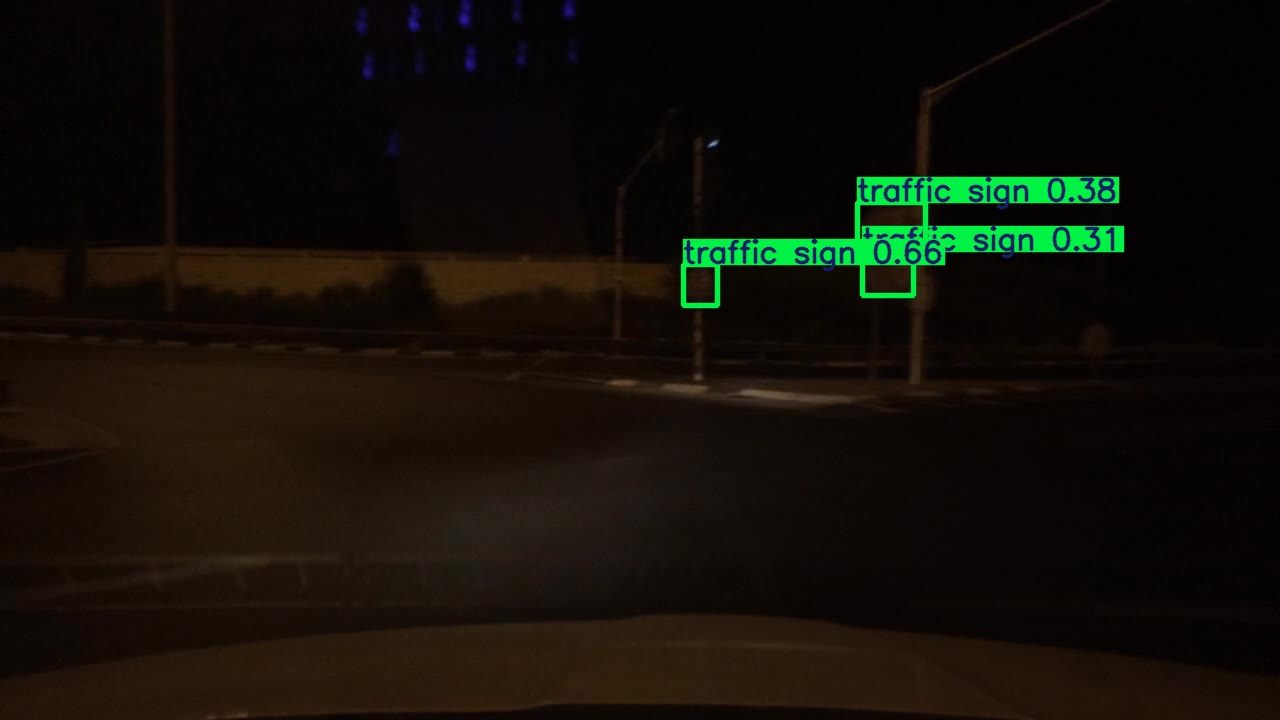

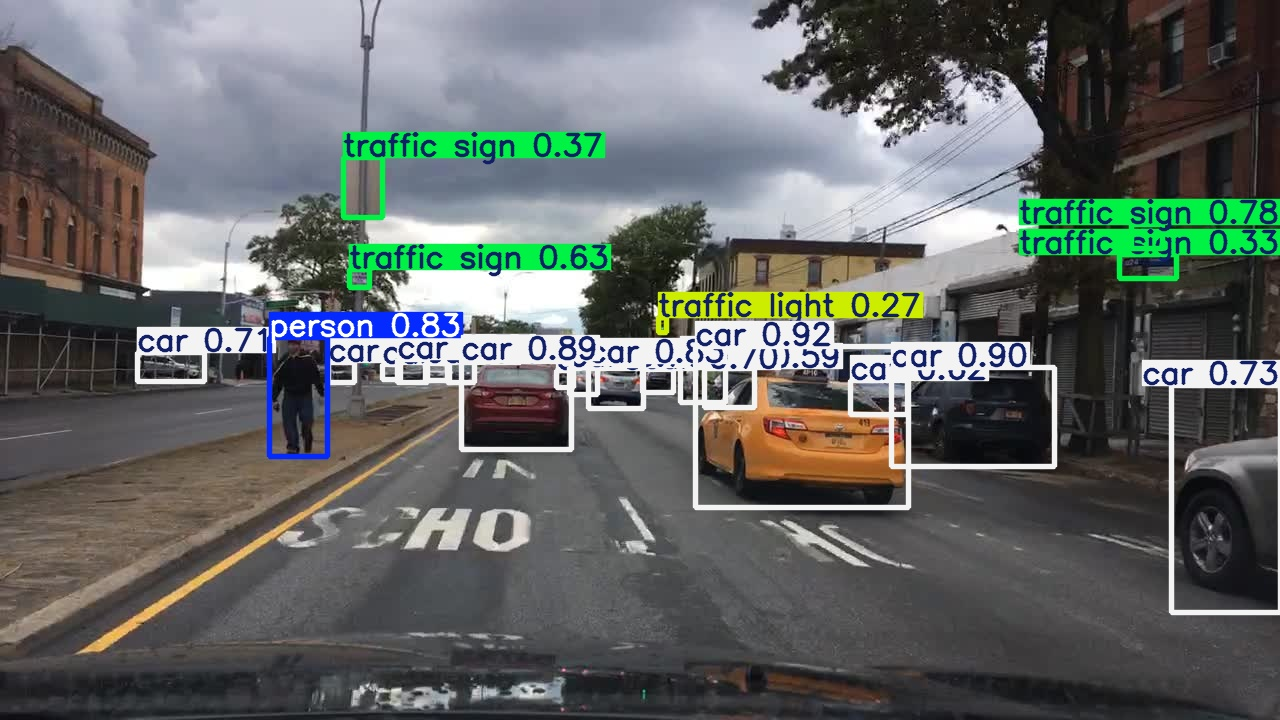

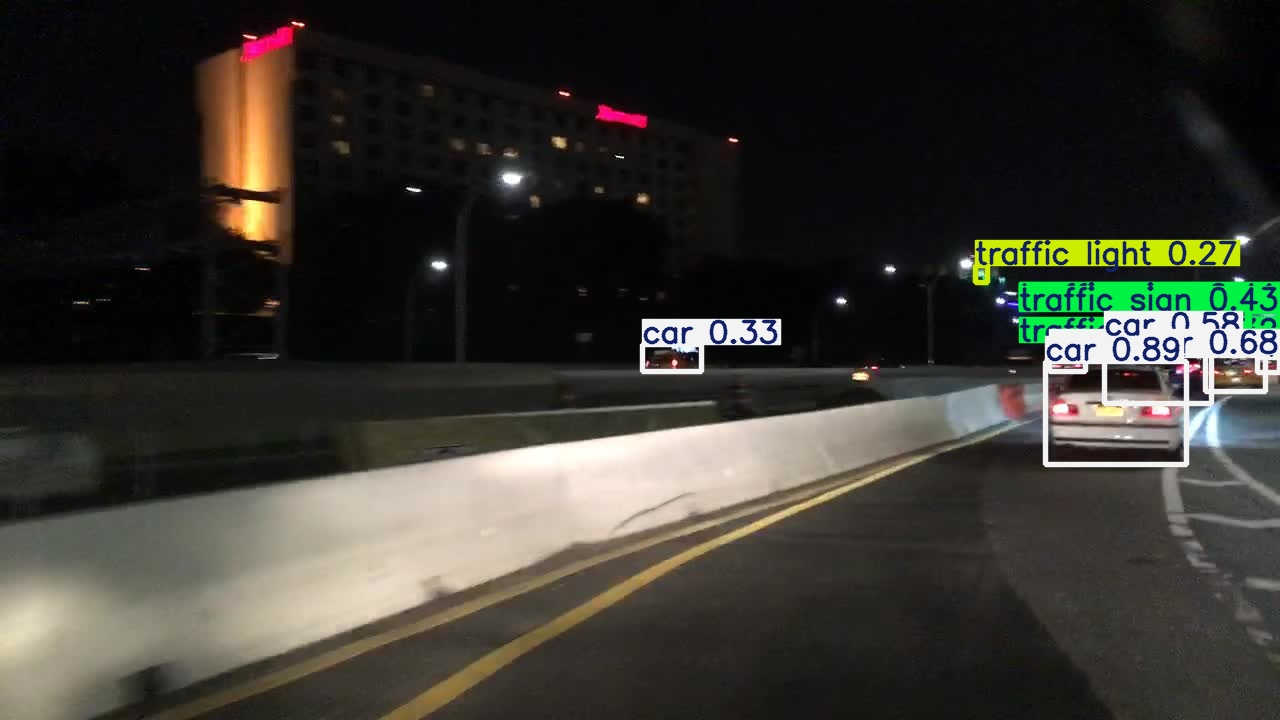

In [35]:
# OPTIONAL: Display a few predictions
import glob
from IPython.display import Image

pred_imgs = glob.glob(test_results_dir + "/preds/*.jpg")[:5]
for img in pred_imgs:
    display(Image(filename=img))

In [ ]:
# export the model in ONNX format for inference

model.export(
    format="onnx",
    opset=12,          # ✨ REQUIRED for OpenCV
    simplify=True,
    dynamic=False       # recommended
)

Ultralytics 8.3.15 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'yolo11m_bdd100k/train_run3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (38.6 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.5/166.5 kB 366.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 279.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 343.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 16.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 19...
O

'yolo11m_bdd100k/train_run3/weights/best.onnx'